In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch.optim.lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
#seed = 20
#torch.manual_seed(seed)
#np.random.seed(seed)

############################ CITATION ################################

# https://github.com/ComputationalDomain/PINNs/blob/main/ODE_Neural_Networks.ipynb

# PyTorch documentation

######################## End of CITATION #############################

torch.set_default_dtype(torch.float64)

num_count_gpu = torch.cuda.device_count()
print(num_count_gpu)

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1
NVIDIA GeForce RTX 2060


In [2]:
n = 10
d = 3
B = 1.0
R0 = 2.2720
N = 101

n = torch.tensor(n).to(device)
d = torch.tensor(d).to(device)
B = torch.tensor(B).to(device)
R0 = torch.tensor(R0).to(device)

a1 = 15
a2 = 20
a3 = 15

In [3]:
class NN_structure(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(1, a1)
        self.hidden_layer2 = nn.Linear(a1, a2)
        self.hidden_layer3 = nn.Linear(a2, a3)
        self.output_layer = nn.Linear(a3, 1)
        
    def forward(self, x):
        x = torch.tanh(self.hidden_layer1(x))
        x = torch.tanh(self.hidden_layer2(x))
        x = torch.tanh(self.hidden_layer3(x))
        output = self.output_layer(x)
        return output
    
NN_2D_Stationary = NN_structure()
NN_2D_Stationary = NN_2D_Stationary.to(device)

In [4]:
def normalized_integral(x, y, dy_dx, y_double_prime):
    # Calculate the spacing
    dx = torch.diff(x,dim=0)

    #print(x.size(), ((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow(y, 0.6e1) - y * y * torch.pow(-0.1e1 + x, 0.2e1) - torch.pow(-0.1e1 + x, 0.5e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * dy_dx * y * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) / 0.2e1 + torch.pow(-0.1e1 + x, 0.6e1) * y_double_prime * y * torch.pow(n, -0.2e1) / 0.4e1 - torch.pow(-0.1e1 + x, 0.6e1) * dy_dx * dy_dx * torch.pow(n, -0.2e1) / 0.2e1 + torch.pow(-0.1e1 + x, 0.2e1))**2)[:-1].size(),dx.size())
    
    # Weighted mean calculation
    
    #weighted_sum = torch.sum(((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow(y * (-x * x + 0.1e1) + 0.1e1 / 0.2e1 + x / 0.2e1, 0.5e1) * torch.pow(-0.1e1 + x, -0.2e1) - y * (-x * x + 0.1e1) - 0.1e1 / 0.2e1 - x / 0.2e1 - torch.pow(-0.1e1 + x, 0.3e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * (dy_dx * (-x * x + 0.1e1) - 0.2e1 * y * x + 0.1e1 / 0.2e1) * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) / 0.2e1 + torch.pow(-0.1e1 + x, 0.4e1) * (d * (-x * x + 0.1e1) - 0.4e1 * dy_dx * x - 0.2e1 * y) * torch.pow(n, -0.2e1) / 0.4e1 + (-torch.pow(-0.1e1 + x, 0.4e1) * torch.pow(dy_dx * (-x * x + 0.1e1) - 0.2e1 * y * x + 0.1e1 / 0.2e1, 0.2e1) * torch.pow(n, -0.2e1) / 0.2e1 + 0.1e1) / (y * (-x * x + 0.1e1) + 0.1e1 / 0.2e1 + x / 0.2e1))**2)[:-1] * dx)
    #weighted_sum = torch.sum(((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow(y, 0.5e1) * torch.pow(-0.1e1 + x, -0.2e1) - y - torch.pow(-0.1e1 + x, 0.3e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * dy_dx * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) / 0.2e1 + torch.pow(-0.1e1 + x, 0.4e1) * y_double_prime * torch.pow(n, -0.2e1) / 0.4e1 + (-torch.pow(-0.1e1 + x, 0.4e1) * dy_dx * dy_dx * torch.pow(n, -0.2e1) / 0.2e1 + 0.1e1) / y)**2)[:-1] * dx)
    
    #weighted_sum = torch.sum(((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow((-x * x + 0.1e1) * y + 0.1e1 / 0.2e1 + x / 0.2e1, 0.6e1) - torch.pow((-x * x + 0.1e1) * y + 0.1e1 / 0.2e1 + x / 0.2e1, 0.2e1) * torch.pow(-0.1e1 + x, 0.2e1) - torch.pow(-0.1e1 + x, 0.5e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * (-0.2e1 * x * y + (-x * x + 0.1e1) * dy_dx + 0.1e1 / 0.2e1) * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) * ((-x * x + 0.1e1) * y + 0.1e1 / 0.2e1 + x / 0.2e1) / 0.2e1 + torch.pow(-0.1e1 + x, 0.6e1) * (-0.2e1 * y - 0.4e1 * x * dy_dx + (-x * x + 0.1e1) * y_double_prime) * torch.pow(n, -0.2e1) * ((-x * x + 0.1e1) * y + 0.1e1 / 0.2e1 + x / 0.2e1) / 0.4e1 - torch.pow(-0.1e1 + x, 0.6e1) * torch.pow(-0.2e1 * x * y + (-x * x + 0.1e1) * dy_dx + 0.1e1 / 0.2e1, 0.2e1) * torch.pow(n, -0.2e1) / 0.2e1 + torch.pow(-0.1e1 + x, 0.2e1))**2)[:-1] * dx)
    weighted_sum = torch.sum(((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow(y, 0.6e1) - y * y * torch.pow(-0.1e1 + x, 0.2e1) - torch.pow(-0.1e1 + x, 0.5e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * dy_dx * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) * y / 0.2e1 + torch.pow(-0.1e1 + x, 0.6e1) * y_double_prime * torch.pow(n, -0.2e1) * y / 0.4e1 - torch.pow(-0.1e1 + x, 0.6e1) * dy_dx * dy_dx * torch.pow(n, -0.2e1) / 0.2e1 + torch.pow(-0.1e1 + x, 0.2e1))**2)[:-1] * dx)
    
    total_length = torch.sum(dx)
    mean_value = weighted_sum / total_length
    
    return mean_value

def loss(x):
    x.requires_grad = True
    y = ((NN_2D_Stationary(x.to(device)) * (-x * x + 1)) + 0.5*(1+x))
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0].to(device)
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0].to(device)

    #print(x.size(),y.size(),dy_dx.size(),y_double_prime.size())
    
    mean_result = normalized_integral(x, y, dy_dx, y_double_prime)
    
    return mean_result

In [5]:
optimizer = torch.optim.Adam(NN_2D_Stationary.parameters(), lr=0.01)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, min_lr=0.00001)

x = torch.cos(torch.linspace(np.pi, 0, N))[:, None]
#print(x)
#print(torch.diff(x)[:, None])

#x = x[1:-1]

print(x.size())

def optimizer_and_loss():
    optimizer.zero_grad()
    l = loss(x.to(device))
    l.backward()

    return l

loss_threshold = 1e-7  # Set your desired loss threshold here
current_loss = float('inf')  # Initialize with a large value

i = 0
while current_loss > loss_threshold:
    optimizer.step(optimizer_and_loss)
    current_loss = optimizer_and_loss().item()  # Update current loss value
    scheduler.step(current_loss)
    
    if i % 1000 == 0:
        print(optimizer_and_loss().item(), optimizer.param_groups[0]['lr'])

    i += 1

print(i)

for name, param in NN_2D_Stationary.named_parameters():
    print(f"Parameter: {name} | Shape: {param.shape} | Values: {param}")

torch.Size([101, 1])
1.6501412510020845 0.01
1.5334978486765265e-06 0.01
4.767881082284127e-07 0.009000000000000001
2.360763242703432e-07 0.005904900000000002
2.0626390161693855e-07 0.004782969000000002
1.1519562996847674e-07 0.0016677181699666583
5391
Parameter: hidden_layer1.weight | Shape: torch.Size([15, 1]) | Values: Parameter containing:
tensor([[ 0.6196],
        [-1.0104],
        [ 1.1309],
        [ 0.6452],
        [-0.5481],
        [ 0.4308],
        [-0.7757],
        [ 0.9383],
        [-0.6472],
        [ 0.6514],
        [ 0.8780],
        [ 0.0938],
        [ 0.4806],
        [ 0.7231],
        [ 0.4389]], device='cuda:0', requires_grad=True)
Parameter: hidden_layer1.bias | Shape: torch.Size([15]) | Values: Parameter containing:
tensor([ 0.3403, -0.4922,  0.9566, -0.9246, -0.8221, -0.1984, -0.6453,  0.7527,
         0.4830,  0.5216,  0.6517, -0.7738,  0.7683,  0.7949,  0.2028],
       device='cuda:0', requires_grad=True)
Parameter: hidden_layer2.weight | Shape: torch.

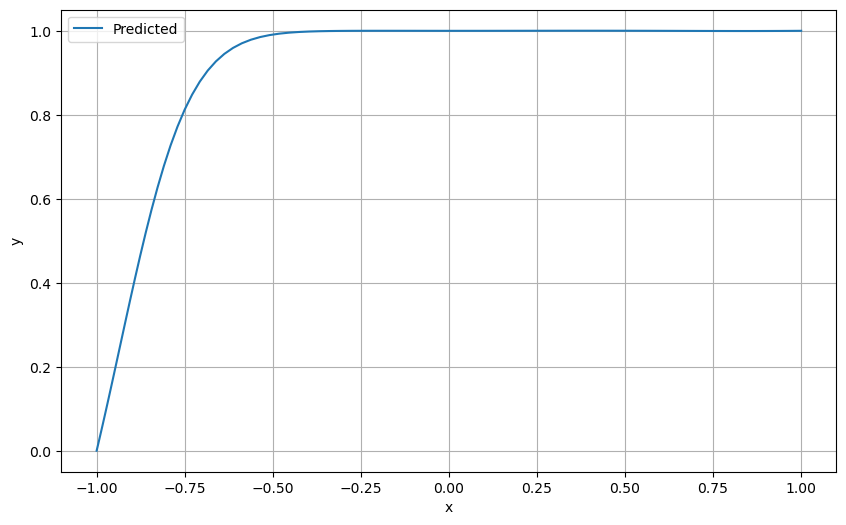

In [6]:
import matplotlib.pyplot as plt

xx = x
with torch.no_grad():
    yy = ((NN_2D_Stationary(xx.to(device)) * (-(xx.to(device)) * (xx.to(device)) + 1)) + 0.5*(1+(xx.to(device))))

xx = xx.cpu().numpy()
yy = yy.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xx, yy, label="Predicted")
#plt.plot(xx, 0.10e2 * np.sqrt(0.10016e0 + 0.8e-3 * xx + 0.1e-2 * pow(xx, 2)), '--', label="Exact")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()

In [7]:
# Save x and y to a text file
with open('B_1.0_R0_2.2720_stationary_sol_NN_init_satisfy_bc_3D.txt', 'w') as f:
    for i in range(len(xx)):
        f.write(f"{xx[i].item()} {yy[i].item()}\n")